<module 'matplotlib.pyplot' from 'c:\\users\\win10-a287\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

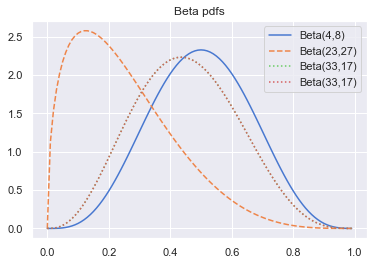

In [66]:
import math
from matplotlib import pyplot as plt
def B(alpha, beta):
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)
def beta_pdf(x, alpha, beta):
    # [0, 1] 구간 밖에서는 밀도가 없음
    if x < 0 or x > 1:
        return 0
    return x ** (alpha - 1) * (1 - x) ** (beta - 1) / B(alpha, beta)

xs = [x / 100.0 for x in range(0,100)]
plt.plot(xs,[beta_pdf(x,alpha=4.5,beta=4.5) for x in xs],'-',label='Beta(4,8)')
plt.plot(xs,[beta_pdf(x,alpha=1.5,beta=4.5) for x in xs],'--',label='Beta(23,27)')
plt.plot(xs,[beta_pdf(x,alpha=3.7,beta=4.5) for x in xs],':',label='Beta(33,17)')
plt.plot(xs,[beta_pdf(x,alpha=3.7,beta=4.5) for x in xs],':',label='Beta(33,17)')
plt.legend()
plt.title('Beta pdfs')
plt

In [37]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing
print('Running on PyMC3 v{}'.format(pm.__version__))
data = pd.read_csv('renfe.csv')
#data.drop('Unnamed: 0', axis = 1, inplace=True)
data = data.sample(frac=0.01, random_state=99)
data.head(3)

Running on PyMC3 v3.7


,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
4738,2019-04-17 08:03:35,VALENCIA,MADRID,2019-05-21 08:00:00,2019-05-21 09:47:00,AVE,33.65,Turista,Promo
8722,2019-05-09 07:12:41,MADRID,BARCELONA,2019-05-25 08:30:00,2019-05-25 11:15:00,AVE,85.10,Turista,Promo
13185,2019-04-24 11:21:26,MADRID,VALENCIA,2019-05-22 17:40:00,2019-05-22 19:20:00,AVE,51.15,Turista,Promo


In [17]:
data.isnull().sum()/len(data)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.096899
train_class    0.000000
fare           0.000000
dtype: float64

In [18]:
data['train_class'] = data['train_class'].fillna(data['train_class'].mode().iloc[0])
data['fare'] = data['fare'].fillna(data['fare'].mode().iloc[0])
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

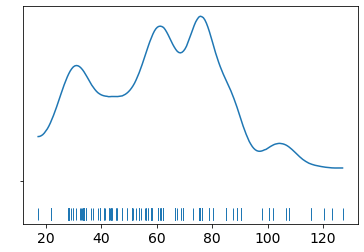

In [19]:
az.plot_kde(data['price'].values, rug=True)
plt.yticks([0], alpha=0);


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [σ, μ]
Sampling 3 chains: 100%|███████████████████████████████████████████████████████████████████| 6000/6000 [01:54<00:00, 52.20draws/s]


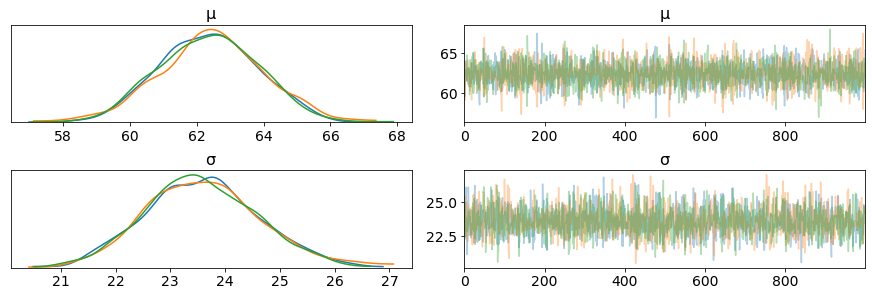

In [21]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0, upper=300)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data['price'].values)
    trace_g = pm.sample(1000, tune=1000)

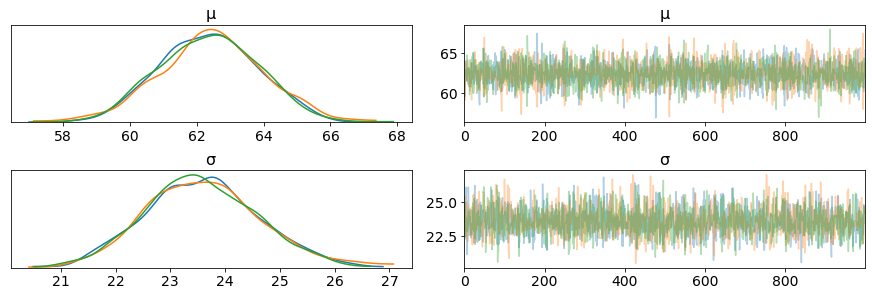

In [22]:
az.plot_trace(trace_g);

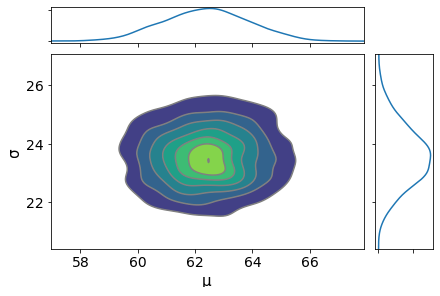

In [23]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

In [24]:
az.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,62.386,1.493,59.797,65.217,0.027,0.019,3113.0,3113.0,3113.0,1991.0,1.0
σ,23.591,1.029,21.744,25.572,0.019,0.013,2987.0,2969.0,2998.0,2000.0,1.0


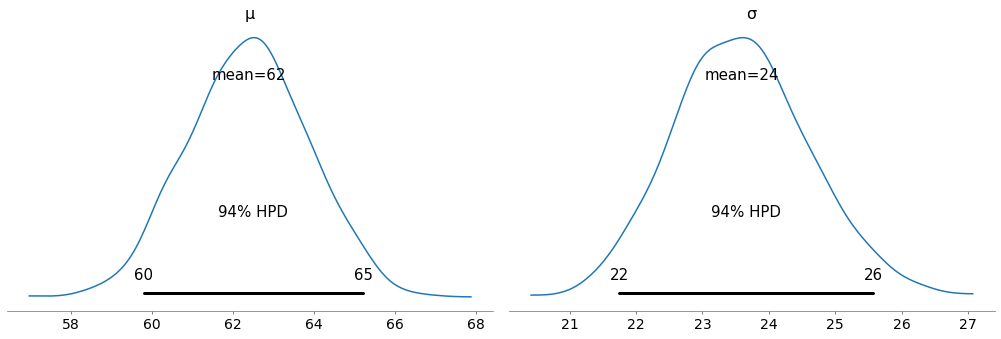

In [25]:
az.plot_posterior(trace_g);

In [26]:
pm.gelman_rubin(trace_g)

{'μ': 1.0000868785505592, 'σ': 1.0001159990493456}

In [27]:
bfmi = pm.bfmi(trace_g)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace_g).values())
(pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

ImportError: ArviZ is not installed. In order to use `plot_energy`:
pip install arviz

In [28]:
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)
np.asarray(ppc['y']).shape


100%|███████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1386.83it/s]


(1000, 258)

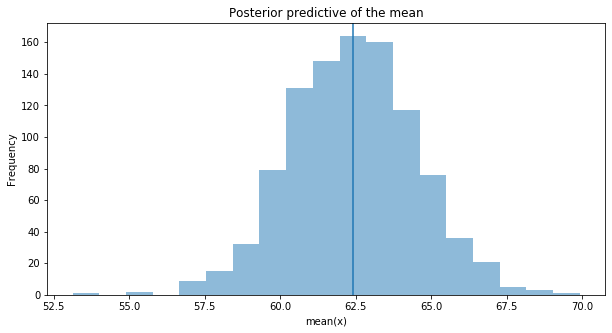

In [29]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(data.price.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

Iteration 1: loglike=-2.334368e+03 (0.005 seconds)
Iteration 2: loglike=-9.053370e+02 (0.005 seconds)
Iteration 3: loglike=1.315671e+02 (0.005 seconds)
Iteration 4: loglike=5.368070e+02 (0.005 seconds)
Iteration 5: loglike=6.163616e+02 (0.005 seconds)
Iteration 6: loglike=6.344636e+02 (0.005 seconds)
Iteration 7: loglike=6.414991e+02 (0.005 seconds)
Iteration 8: loglike=6.449581e+02 (0.005 seconds)
Iteration 9: loglike=6.468648e+02 (0.005 seconds)
Iteration 10: loglike=6.480065e+02 (0.005 seconds)
Iteration 11: loglike=6.486552e+02 (0.005 seconds)
Iteration 12: loglike=6.490657e+02 (0.005 seconds)
Iteration 13: loglike=6.494163e+02 (0.005 seconds)
Iteration 14: loglike=6.495944e+02 (0.005 seconds)
Iteration 15: loglike=6.497025e+02 (0.005 seconds)
Iteration 16: loglike=6.497739e+02 (0.005 seconds)
Iteration 17: loglike=6.498256e+02 (0.005 seconds)
Iteration 18: loglike=6.498852e+02 (0.005 seconds)
Iteration 19: loglike=6.499210e+02 (0.005 seconds)
Iteration 20: loglike=6.499397e+02 (0.

c:\users\win10-a287\appdata\local\programs\python\python37\lib\site-packages\bayespy\plot.py:383: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax0 = fig.add_subplot(M, N, 1)
c:\users\win10-a287\appdata\local\programs\python\python37\lib\site-packages\bayespy\plot.py:388: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(M, N, i+1, sharex=ax0)


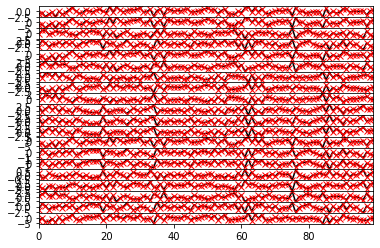

In [52]:
import numpy
numpy.random.seed(1)
M = 20
N = 100
import numpy as np
x = np.random.randn(N, 2)
w = np.random.randn(M, 2)
f = np.einsum('ik,jk->ij', w, x)
y = f + 0.1*np.random.randn(M, N)
D = 10
from bayespy.nodes import GaussianARD, Gamma, SumMultiply
X = GaussianARD(0, 1, plates=(1,N), shape=(D,))
alpha = Gamma(1e-5, 1e-5, plates=(D,))
C = GaussianARD(0, alpha, plates=(M,1), shape=(D,))
F = SumMultiply('d,d->', X, C)
tau = Gamma(1e-5, 1e-5)
Y = GaussianARD(F, tau)
Y.observe(y)
from bayespy.inference import VB
Q = VB(Y, X, C, alpha, tau)
C.initialize_from_random()
from bayespy.inference.vmp.transformations import RotateGaussianARD
rot_X = RotateGaussianARD(X)
rot_C = RotateGaussianARD(C, alpha)
from bayespy.inference.vmp.transformations import RotationOptimizer
R = RotationOptimizer(rot_X, rot_C, D)
Q.set_callback(R.rotate)
Q.update(repeat=1000)
import bayespy.plot as bpplt
bpplt.plot(F)
bpplt.plot(f, color='r', marker='x', linestyle='None')

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns


sns.set(style="darkgrid", palette="muted")


def simulate_linear_data(N, beta_0, beta_1, eps_sigma_sq):
    """
    Simulate a random dataset using a noisy
    linear process.

    N: Number of data points to simulate
    beta_0: Intercept
    beta_1: Slope of univariate predictor, X
    """
    # Create a pandas DataFrame with column 'x' containing
    # N uniformly sampled values between 0.0 and 1.0
    df = pd.DataFrame(
        {"x": 
            np.random.RandomState(42).choice(
                map(
                    lambda x: float(x)/100.0, 
                    np.arange(N)
                ), N, replace=False
            )
        }
    )

    # Use a linear model (y ~ beta_0 + beta_1*x + epsilon) to 
    # generate a column 'y' of responses based on 'x'
    eps_mean = 0.0
    df["y"] = beta_0 + beta_1*df["x"] + np.random.RandomState(42).normal(
        eps_mean, eps_sigma_sq, N
    )

    return df


def glm_mcmc_inference(df, iterations=5000):
    """
    Calculates the Markov Chain Monte Carlo trace of
    a Generalised Linear Model Bayesian linear regression 
    model on supplied data.

    df: DataFrame containing the data
    iterations: Number of iterations to carry out MCMC for
    """
    # Use PyMC3 to construct a model context
    basic_model = pm.Model()
    with basic_model:
        # Create the glm using the Patsy model syntax
        # We use a Normal distribution for the likelihood
        pm.glm.glm("y ~ x", df, family=pm.glm.families.Normal())

        # Use Maximum A Posteriori (MAP) optimisation as initial value for MCMC
        start = pm.find_MAP()

        # Use the No-U-Turn Sampler
        step = pm.NUTS()

        # Calculate the trace
        trace = pm.sample(
            iterations, step, start, 
            random_seed=42, progressbar=True
        )

    return trace


# These are our "true" parameters
beta_0 = 1.0  # Intercept
beta_1 = 2.0  # Slope

# Simulate 100 data points, with a variance of 0.5
N = 200
eps_sigma_sq = 0.5

# Simulate the "linear" data using the above parameters
df = simulate_linear_data(N, beta_0, beta_1, eps_sigma_sq)

# Plot the data, and a frequentist linear regression fit
# using the seaborn package
sns.lmplot(x="x", y="y", data=df, size=10)
plt.xlim(0.0, 1.0)

trace = glm_mcmc_inference(df, iterations=5000)
pm.traceplot(trace[500:])
plt.show()

# Plot a sample of posterior regression lines
sns.lmplot(x="x", y="y", data=df, size=10, fit_reg=False)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 4.0)
pm.glm.plot_posterior_predictive(trace, samples=100)
x = np.linspace(0, 1, N)
y = beta_0 + beta_1*x
plt.plot(x, y, label="True Regression Line", lw=3., c="green")
plt.legend(loc=0)
plt.show()

ValueError: a must be 1-dimensional or an integer

In [64]:
import numpy as np
k = 2 # slope
c = 5 # bias
s = 2 # noise standard deviation
x = np.asarray([37,38,39,40,41,42,43,44,45,46])
y = k*x + c + s*np.random.randn(100)
X = np.vstack([x, np.ones(len(x))]).T
from bayespy.nodes import GaussianARD
B = GaussianARD(0, 1e-6, shape=(2,))
from bayespy.nodes import SumMultiply
F = SumMultiply('i,i', B, X)
from bayespy.nodes import Gamma
tau = Gamma(1e-3, 1e-3)
Y = GaussianARD(F, tau)

Y.observe(y)
from bayespy.inference import VB
Q = VB(Y, B, tau)
Q.update(repeat=1000)

xh = np.linspace(-5, 15, 100)
Xh = np.vstack([xh, np.ones(len(xh))]).T
Fh = SumMultiply('i,i', B, Xh)
import bayespy.plot as bpplt
bpplt.pyplot.figure()
bpplt.plot(Fh, x=xh, scale=2)
bpplt.plot(y, x=x, color='r', marker='x', linestyle='None')
bpplt.plot(k*xh+c, x=xh, color='r');
bpplt.pyplot.figure()
bpplt.pdf(tau, np.linspace(1e-6,1,100), color='k')
bpplt.pyplot.axvline(s**(-2), color='r');

ValueError: operands could not be broadcast together with shapes (10,) (100,) 